# Google Colab instructions

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Change directory

In [2]:
%cd /content/drive/My Drive/Image_Captioning/data/flickr30k_images

/content/drive/My Drive/Image_Captioning/data/flickr30k_images


In [3]:
!ls

 22_checkpoint.keras   glove.6B.50d.txt        'test images'
 22_logs	       glove.6B.zip	        test_images
 checkpoints	       Image_captioning.ipynb   transfer_test.pkl
 flickr30k_images      lstm-model.hdf5	        transfer_train.pkl
 glove.6B.100d.txt     results.csv	        transfer_val_test.pkl
 glove.6B.200d.txt     Results.csv	        transfer_val_train.pkl
 glove.6B.300d.txt     RESULTS.csv


# Import Libraries

In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input 
import tensorflow.keras.preprocessing.image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import backend as K
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

import re
import nltk
import string
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, add
from tensorflow.keras.utils import to_categorical

# Load CSV file

In [5]:
df = pd.read_csv('Results.csv')
df.head(20)

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their...
1,1000092795.jpg,1,"Two young , White males are outside near many..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
5,10002456.jpg,0,Several men in hard hats are operating a gian...
6,10002456.jpg,1,Workers look down from up above on a piece of...
7,10002456.jpg,2,Two men working on a machine wearing hard hats .
8,10002456.jpg,3,Four men on top of a tall structure .
9,10002456.jpg,4,Three men on a large rig .


## Count total number of images

In [6]:
num_images = df[df[' comment_number']==0].count().values[0]
num_images

31783

## Get images name

In [7]:
images_name = df[df[' comment_number']==0]['image_name'].values
images_name

array(['1000092795.jpg', '10002456.jpg', '1000268201.jpg', ...,
       '997876722.jpg', '99804383.jpg', '998845445.jpg'], dtype=object)

## Pretrained image model ( MobileNet )

In [8]:
encode_model = MobileNet(weights='imagenet')
encode_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________

## Make transfer values the ouput of the model

In [9]:
encode_model = Model(encode_model.input, encode_model.layers[-6].output)
encode_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

## Get images input size that the model expects

In [10]:
img_size = K.int_shape(encode_model.input)[1:3]
img_size

(224, 224)

## Get the size of the model's output ( transfer values )

In [11]:
transfer_values_size = K.int_shape(encode_model.output)[1]
transfer_values_size

1024

## Train test splitting of the images

In [12]:
train_size= int(0.7*len(images_name))
images_name_train = images_name[:train_size]
images_name_test = images_name[train_size:]

In [13]:
images_name_train

array(['1000092795.jpg', '10002456.jpg', '1000268201.jpg', ...,
       '4690280732.jpg', '469029994.jpg', '4690414746.jpg'], dtype=object)

In [14]:
images_name_test

array(['4690435409.jpg', '4690454050.jpg', '4690670113.jpg', ...,
       '997876722.jpg', '99804383.jpg', '998845445.jpg'], dtype=object)

# Process all images and return the transfer values

We now make function for processing all images in the data-set using the pre-trained image model and saving the transfer-values in a pickle file so they can be reloaded quickly.

In [15]:
def process_images(data_dir, filenames, batch_size):
  # Pre-allocate input-batch-array for images.
  input_shape = (batch_size,) + img_size + (3,)
  image_batch = np.zeros(shape=input_shape, dtype=np.float16)

  # Pre-allocate output-array for transfer-values.
  # Note that we use 16-bit floating-points to save memory.
  output_shape = (len(filenames), transfer_values_size)
  transfer_values = np.zeros(shape=output_shape, dtype=np.float16)

  # Initialize index into the filenames.
  start_index = 0

  # Process batches of image-files.
  while start_index < len(filenames):
    # End-index for this batch.
    end_index = start_index + batch_size

    # Ensure end-index is within bounds.
    if end_index > len(filenames):
      end_index = len(filenames)

    # The last batch may have a different batch-size.
    current_batch_size = end_index - start_index

    # Load all the images in the batch.
    for i, filename in enumerate(filenames[start_index:end_index]):
      # Path for the image-file.
      img_path = os.path.join(data_dir, filename)
      img = image.load_img(img_path, target_size=img_size)
      # Convert a PIL image to a numpy array
      x = image.img_to_array(img)
      # Expand to 2D array
      x = np.expand_dims(x, axis=0)
      # Perform any preprocessing needed by MobileNet
      x = preprocess_input(x)

      # Save the image for later use.
      image_batch[i] = x

    # Use the pre-trained image-model to process the image.
    # Note that the last batch may have a different size,
    # so we only use the relevant images.
    transfer_values_batch = encode_model.predict(image_batch[0:current_batch_size])

    # Save the transfer-values in the pre-allocated array.
    transfer_values[start_index:end_index] = transfer_values_batch[0:current_batch_size]
              
    # Increase the index for the next loop-iteration.
    start_index = end_index

  return transfer_values

## Get transfer values of the training set and save it to a pickle file

In [ ]:
batch_size=128
data_dir = '/content/drive/My Drive/Image_Captioning/data/flickr30k_images/flickr30k_images/'

transfer_values_train = process_images(data_dir, images_name_train, batch_size)

train_path = os.path.join('/content/drive/My Drive/Image_Captioning/data/flickr30k_images/',f'transfer_val_train.pkl')
with open(train_path, "wb") as fp:
   pickle.dump(transfer_values_train, fp)

In [ ]:
len(transfer_values_train)

22248

## Get transfer values of the testing set and save it to a pickle file

In [ ]:
transfer_values_test = process_images(data_dir, images_name_test, batch_size)

test_path = os.path.join('/content/drive/My Drive/Image_Captioning/data/flickr30k_images/',f'transfer_val_test.pkl')
with open(test_path, "wb") as fp:
    pickle.dump(transfer_values_test, fp)

## Load pickle file of train transfer values

In [16]:
train_path = os.path.join('/content/drive/My Drive/Image_Captioning/data/flickr30k_images/', f'transfer_val_train.pkl')
with open(train_path, "rb") as fw:
  transfer_train = pickle.load(fw)

In [17]:
transfer_train

array([[4.0381e-01, 1.3440e-01, 2.0447e-01, ..., 1.8877e+00, 1.0703e+00,
        1.5430e-01],
       [2.7539e-01, 1.0205e+00, 2.1021e-01, ..., 0.0000e+00, 9.0869e-01,
        8.3351e-04],
       [6.1377e-01, 7.9248e-01, 6.3232e-02, ..., 6.9238e-01, 1.2148e+00,
        2.7539e-01],
       ...,
       [2.0820e+00, 1.1169e-01, 3.9453e-01, ..., 3.2480e+00, 8.7158e-01,
        5.0537e-01],
       [5.7178e-01, 2.8613e-01, 8.9941e-01, ..., 6.8848e-01, 8.6182e-01,
        6.8115e-01],
       [7.3389e-01, 4.4482e-01, 6.3623e-01, ..., 4.9731e-01, 0.0000e+00,
        1.1533e+00]], dtype=float16)

## Load pickle file of test transfer values

In [18]:
test_path = os.path.join('/content/drive/My Drive/Image_Captioning/data/flickr30k_images/', f'transfer_val_test.pkl')
with open(test_path, "rb") as fr:
  transfer_test = pickle.load(fr)

transfer_test

# Repeat each row of transfer values 5 times as each image has 5 captions

Here, we are training on the all captions, so we will repeat each image five times. It will be much more efficient to use all captions.

In [20]:
transfer_value_train = np.repeat(transfer_train,5, axis=0)
transfer_value_train

array([[0.4038, 0.1344, 0.2045, ..., 1.888 , 1.07  , 0.1543],
       [0.4038, 0.1344, 0.2045, ..., 1.888 , 1.07  , 0.1543],
       [0.4038, 0.1344, 0.2045, ..., 1.888 , 1.07  , 0.1543],
       ...,
       [0.734 , 0.4448, 0.636 , ..., 0.4973, 0.    , 1.153 ],
       [0.734 , 0.4448, 0.636 , ..., 0.4973, 0.    , 1.153 ],
       [0.734 , 0.4448, 0.636 , ..., 0.4973, 0.    , 1.153 ]],
      dtype=float16)

In [21]:
transfer_value_train.shape

(111240, 1024)

In [22]:
transfer_value_test = np.repeat(transfer_test,5, axis=0)
transfer_value_test

array([[0.7925  , 0.09265 , 0.0748  , ..., 0.05154 , 0.004456, 0.7524  ],
       [0.7925  , 0.09265 , 0.0748  , ..., 0.05154 , 0.004456, 0.7524  ],
       [0.7925  , 0.09265 , 0.0748  , ..., 0.05154 , 0.004456, 0.7524  ],
       ...,
       [0.233   , 0.147   , 0.7603  , ..., 0.      , 1.039   , 0.4614  ],
       [0.233   , 0.147   , 0.7603  , ..., 0.      , 1.039   , 0.4614  ],
       [0.233   , 0.147   , 0.7603  , ..., 0.      , 1.039   , 0.4614  ]],
      dtype=float16)

In [23]:
transfer_value_test.shape

(47675, 1024)

# Get all captions of the images

In [24]:
captions = df[' comment'].values.tolist()
captions[:5]

[' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 ' Two young , White males are outside near many bushes .',
 ' Two men in green shirts are standing in a yard .',
 ' A man in a blue shirt standing in a garden .',
 ' Two friends enjoy time spent together .']

## Check if there is any null value

In [25]:
df[' comment'].isnull().sum()

0

# Captions processing

We must pull in the Flickr dataset captions and clean them of punctuation.

## Convert all captions into lowercase characters and remove punctuations

In [26]:
def clean_text(txt):
    txt = txt.lower()
    table = str.maketrans('', '', string.punctuation)
    txt = " ".join(w.translate(table) for w in txt.split())
    
    return txt

## wrap all captions in the start and end markers

Before we can start processing the text, we first need to mark the beginning and end of each text-sequence with unique words that most likely aren't present in the data, We will later use the start token to begin the process of generating a caption. Encountering the stop token in the generated text will let us know the process is complete.

In [27]:
start = 'sss '
end = 'eee'
captions = [start + clean_text(caption) + end for caption in captions]
captions[:10]

['sss two young guys with shaggy hair look at their hands while hanging out in the yard eee',
 'sss two young  white males are outside near many bushes eee',
 'sss two men in green shirts are standing in a yard eee',
 'sss a man in a blue shirt standing in a garden eee',
 'sss two friends enjoy time spent together eee',
 'sss several men in hard hats are operating a giant pulley system eee',
 'sss workers look down from up above on a piece of equipment eee',
 'sss two men working on a machine wearing hard hats eee',
 'sss four men on top of a tall structure eee',
 'sss three men on a large rig eee']

In [28]:
len(captions)

158915

## Train test splitting of the captions

In [29]:
train_size = int(0.7*len(captions))
train_captions = captions[:train_size]
test_captions = captions[train_size:]

In [30]:
len(test_captions)

47675

## Tokenize the training set

Neural Networks cannot work directly on text data. We use a two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into integer tokens. The second step is to convert integer tokens into vectors of floating point numbers using an embedding layer.

In [31]:
tk = Tokenizer()
tk.fit_on_texts(train_captions)

## Map each word to a certain index

In [32]:
#index_to_word = dict(zip(tk.word_index.values(), tk.word_index.keys()))
index_to_word = {id: word for word, id in tk.word_index.items()}

## Calculate total number of words

In [33]:
total_words = len(tk.word_index) + 1
total_words

18128

## Vectorize the training and testing set

In [34]:
train_captions = tk.texts_to_sequences(train_captions)
test_captions = tk.texts_to_sequences(test_captions)

In [35]:
train_captions[:10]

[[2, 13, 21, 340, 11, 1934, 111, 187, 17, 63, 161, 25, 327, 73, 4, 5, 435, 3],
 [2, 13, 21, 20, 696, 14, 56, 77, 185, 1290, 3],
 [2, 13, 33, 4, 47, 258, 14, 32, 4, 1, 435, 3],
 [2, 1, 8, 4, 1, 26, 22, 32, 4, 1, 720, 3],
 [2, 13, 443, 825, 598, 8736, 136, 3],
 [2, 119, 33, 4, 328, 263, 14, 1152, 1, 818, 3167, 2378, 3],
 [2, 204, 187, 37, 64, 50, 310, 6, 1, 296, 10, 412, 3],
 [2, 13, 33, 106, 6, 1, 392, 18, 328, 263, 3],
 [2, 105, 33, 6, 100, 10, 1, 389, 479, 3],
 [2, 44, 33, 6, 1, 53, 4506, 3]]

## Padding the training and testing data

In [36]:
max_len = max([len(i) for i in train_captions])
train_captions = pad_sequences(train_captions, maxlen=max_len, padding='post')
test_captions = pad_sequences(test_captions, maxlen=max_len, padding='post')

# Download glove embeddings

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-11-29 13:11:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-11-29 13:11:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-11-29 13:11:51--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!ls

flickr30k_images  Image_captioning.ipynb  Results.csv	     transfer_train.pkl
glove.6B.zip	  results.csv		  transfer_test.pkl


In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls

flickr30k_images   glove.6B.50d.txt	   Results.csv
glove.6B.100d.txt  glove.6B.zip		   transfer_test.pkl
glove.6B.200d.txt  Image_captioning.ipynb  transfer_train.pkl
glove.6B.300d.txt  results.csv


## Load glove embeddings

In [37]:
embeddings_index = {}
f = open('glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [38]:
len(embeddings_index)

400000

## Build an embedding matrix

We build an embedding matrix from Glove. We will directly copy this matrix to the weight matrix of the neural network.

In [39]:
embedding_dim = 200
embedding_matrix = np.zeros((total_words, embedding_dim))

for word, i in tk.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # Words not found in the embedding index will be all zeros
    embedding_matrix[i] = embedding_vector
     
embedding_matrix.shape

(18128, 200)

# Implement LSTM model

In [40]:
state_size = 512
embedding_size = 200

inputs1 = Input(shape=(transfer_values_size,))
fe1 = Dropout(0.3)(inputs1)
decoder_transfer_map = Dense(state_size, activation='tanh')(fe1)
inputs2 = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=total_words, output_dim=embedding_size)(inputs2)
fe2 = Dropout(0.3)(decoder_embedding)
decoder_lstm = LSTM(state_size, return_sequences=True)(fe2)
decoder_inputs = add([decoder_transfer_map, decoder_lstm])
decoder_dense = Dense(state_size, activation='tanh')(decoder_inputs)
decoder_output = Dense(total_words, activation='softmax')(decoder_dense)
lstm_model = Model(inputs=[inputs1, inputs2], outputs=decoder_output)

In [41]:
total_words

18128

In [42]:
test_captions.shape

(47675, 80)

## Generate input and output of the decoder

In [44]:
decoder_input_train = train_captions[:, 0:-1]
decoder_output_train = train_captions[:, 1:]

decoder_input_test = test_captions[:, 0:-1]
decoder_output_test = test_captions[:, 1:]

In [42]:
decoder_output_train.shape

(111240, 79)

In [ ]:
lstm_model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 200)    3625600     input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1024)         0           input_2[0][0]                    
_______________________________________________________________________________________

## Apply glove embedding to the model

In [ ]:
lstm_model.layers[2].set_weights([embedding_matrix])
lstm_model.layers[2].trainable = False

In [43]:
lstm_model.compile(optimizer=Adam(lr=0.001), metrics='accuracy', loss='sparse_categorical_crossentropy')

## Create The appropriate callbacks for keras

During training we want to save checkpoints and log the progress to TensorBoard, so we create the appropriate callbacks for Keras

In [40]:

# This is the callback for writing checkpoints during training
callback_checkpoint = ModelCheckpoint(filepath='22_checkpoint.keras', verbose=1, save_weights_only=True)

# This is the callback for writing the TensorBoard log during training
callback_tensorboard = TensorBoard(log_dir='./22_logs/', histogram_freq=0, write_graph=False)
callbacks = [callback_checkpoint, callback_tensorboard]

# Train the model

In [ ]:
history = lstm_model.fit([transfer_value_train, decoder_input_train], decoder_output_train, 
                         epochs=50, verbose=2, batch_size=64,
                         validation_data=([transfer_value_test, decoder_input_test], decoder_output_test), callbacks=callbacks)

Epoch 1/50
Instructions for updating:
use `tf.profiler.experimental.stop` instead.

Epoch 00001: saving model to 22_checkpoint.keras
1739/1739 - 510s - loss: 0.4336 - accuracy: 0.9082 - val_loss: 0.6627 - val_accuracy: 0.8849
Epoch 2/50

Epoch 00002: saving model to 22_checkpoint.keras
1739/1739 - 507s - loss: 0.4327 - accuracy: 0.9082 - val_loss: 0.6639 - val_accuracy: 0.8856
Epoch 3/50

Epoch 00003: saving model to 22_checkpoint.keras
1739/1739 - 506s - loss: 0.4324 - accuracy: 0.9082 - val_loss: 0.6647 - val_accuracy: 0.8850
Epoch 4/50

Epoch 00004: saving model to 22_checkpoint.keras
1739/1739 - 505s - loss: 0.4324 - accuracy: 0.9082 - val_loss: 0.6619 - val_accuracy: 0.8861
Epoch 5/50

Epoch 00005: saving model to 22_checkpoint.keras
1739/1739 - 505s - loss: 0.4323 - accuracy: 0.9082 - val_loss: 0.6668 - val_accuracy: 0.8847
Epoch 6/50

Epoch 00006: saving model to 22_checkpoint.keras
1739/1739 - 505s - loss: 0.4321 - accuracy: 0.9083 - val_loss: 0.6646 - val_accuracy: 0.8852
Epoc

## Load the checkpoints

You can reload the last saved checkpoint so you don't have to train the model every time you want to use it.

In [38]:
lstm_model.load_weights('22_checkpoint.keras')

## Get tokens of start and end markers

In [39]:
token_start = tk.word_index[start.strip()]
token_end = tk.word_index[end.strip()]
token_end

3

# Generate captions from the output of the LSTM model

In [40]:
def caption_generator(image_path, max_tokens=30):
  # Load the desired image
  img = image.load_img(image_path, target_size=img_size)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  
  # Get the pre-computed transfer-values for the desired image.
  # These are the outputs of the pre-trained image-model.
  transfer_values = encode_model.predict(x)

  shape = (1, max_tokens)
  decoder_input_data = np.zeros(shape=shape, dtype=np.int)

  # The first input-token is the special start-token for 'sss '.
  token_int = token_start

  # Initialize an empty output-text.
  output_text = ''

  # Initialize the number of tokens we have processed.
  count_tokens = 0

  while token_int != token_end and count_tokens < max_tokens:
    # Update the input-sequence to the decoder with the last token that was sampled.
    # In the first iteration this will set the first element to the start-token.
    decoder_input_data[0, count_tokens] = token_int

    # Input this data to the decoder and get the predicted output.
    decoder_output = lstm_model.predict([transfer_values, decoder_input_data])

    # Get the last predicted token as a one-hot encoded array.
    token_onehot = decoder_output[0, count_tokens, :]

    # Convert to an integer-token.
    token_int = np.argmax(token_onehot)

    # Lookup the word corresponding to this integer-token.
    sampled_word = index_to_word[token_int]

    # Append the word to the output-text.
    output_text += " " + sampled_word

    # Increment the token-counter.
    count_tokens += 1

  # This is the sequence of tokens output by the decoder.
  output_tokens = decoder_input_data[0]

  # Plot the image.
  plt.imshow(img)
  plt.show()
    
  # Print the predicted caption.
  print("Predicted caption:")
  print(output_text)

# Evaluate Performance on Test Data from Flicker30k

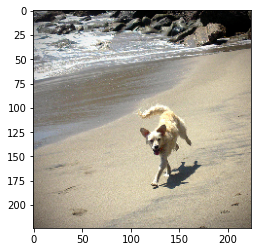

Predicted caption:
 a dog running on the beach eee


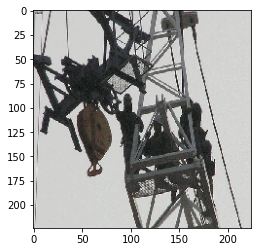

Predicted caption:
 a man in a white shirt is climbing a vine eee


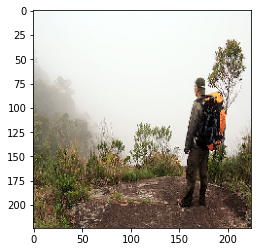

Predicted caption:
 a man in a black shirt and jeans is walking down the side of a country road eee


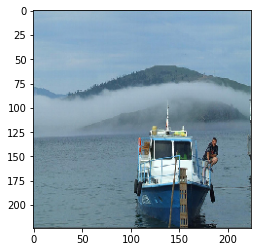

Predicted caption:
 a man in a blue shirt is fishing in water eee


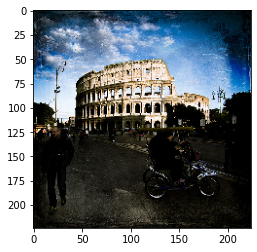

Predicted caption:
 a man in a black shirt and jeans is walking down the street eee


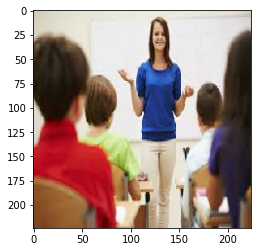

Predicted caption:
 a woman in a blue shirt and a man in a white shirt are sitting on the floor eee


In [42]:
test_data_dir = '/content/drive/My Drive/Image_Captioning/data/flickr30k_images/test_images/'
for imagename in os.listdir(test_data_dir):
  dir = os.path.join(test_data_dir, imagename)
  caption_generator(dir, 30)